In [ ]:
import shap
from shap import TreeExplainer
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib as plt
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xgb_model = load('C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/ml-xai/XGBoost_model.pkl')
lgbm_model = load('C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/ml-xai/lightgbm_model.pkl')
#ensemble_predict = load("C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/non-xai/ensemble_model.pkl")

def ensemble_predict(X):
    if X is None or X.empty:
        raise ValueError("Input data is not defined or is empty.")
    xgb_pred = xgb_model.predict_proba(X)[:, 1]
    lgbm_pred = lgbm_model.predict_proba(X)[:, 1]
    ensemble_pred = (xgb_pred + lgbm_pred) / 2
    return ensemble_pred

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<font color="bluegrey" size=+1.0><b>Preprocess</b></font>

In [3]:
train_data = pd.read_csv('train_data.csv')
X_train = train_data.drop(columns=['stroke'])
y_train = train_data['stroke']

test_data = pd.read_csv('test_data.csv')
X_test = test_data.drop(columns=['stroke'])
y_test = test_data['stroke']

# === Define column types ===
categorical_columns = ['work_type', 'smoking_status', 'bmi_category']
numerical_columns = ['age', 'avg_glucose_level', 'gender', 'ever_married', 'Residence_type']

# === Preprocessing function ===
def preprocess_data(X_train, X_test, categorical_columns, numerical_columns):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ]
    )
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)
    
    print(f"Processed Training Data Shape: {X_train_processed.shape}")
    print(f"Processed Testing Data Shape: {X_test_processed.shape}")
    
    return X_train_processed, X_test_processed, pipeline

# === Preprocess data ===
X_train_processed, X_test_processed, pipeline = preprocess_data(X_train, X_test, categorical_columns, numerical_columns)

# === Apply SMOTE on preprocessed data ===
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print("Original dataset shape:", X_train_processed.shape, "Target distribution:", y_train.value_counts().to_dict())
print("Balanced dataset shape:", X_train_balanced.shape, "Target distribution:", dict(pd.Series(y_train_balanced).value_counts()))

Processed Training Data Shape: (4087, 18)
Processed Testing Data Shape: (1022, 18)
Original dataset shape: (4087, 18) Target distribution: {0: 3888, 1: 199}
Balanced dataset shape: (7776, 18) Target distribution: {0: 3888, 1: 3888}


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


<font color="bluegrey" size=+1.0><b>Ensemble (XGBoost + LightGBM)</b></font>

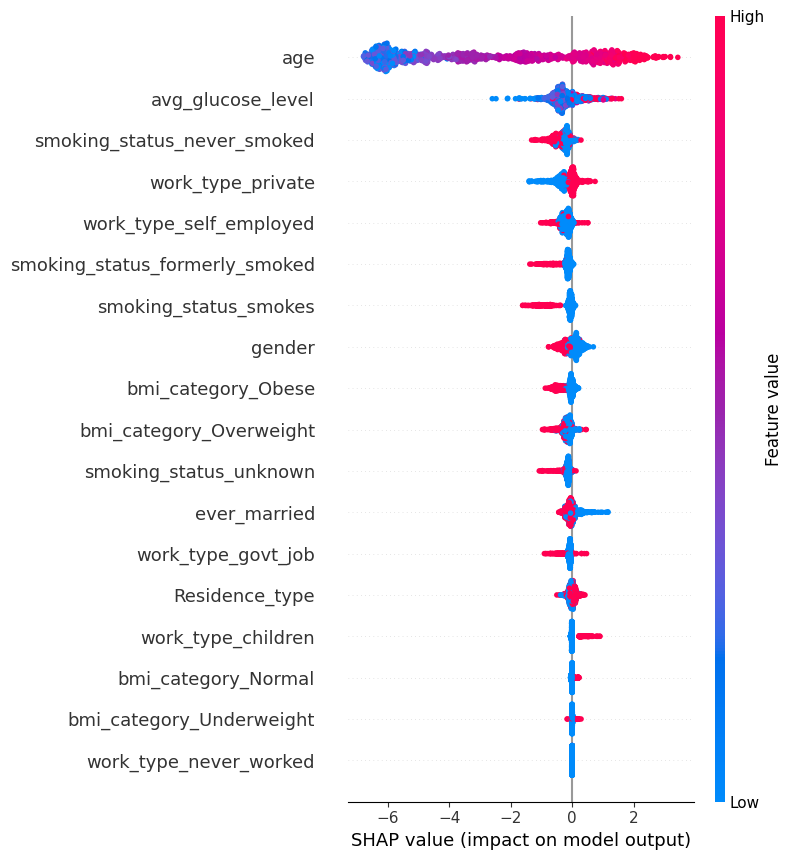

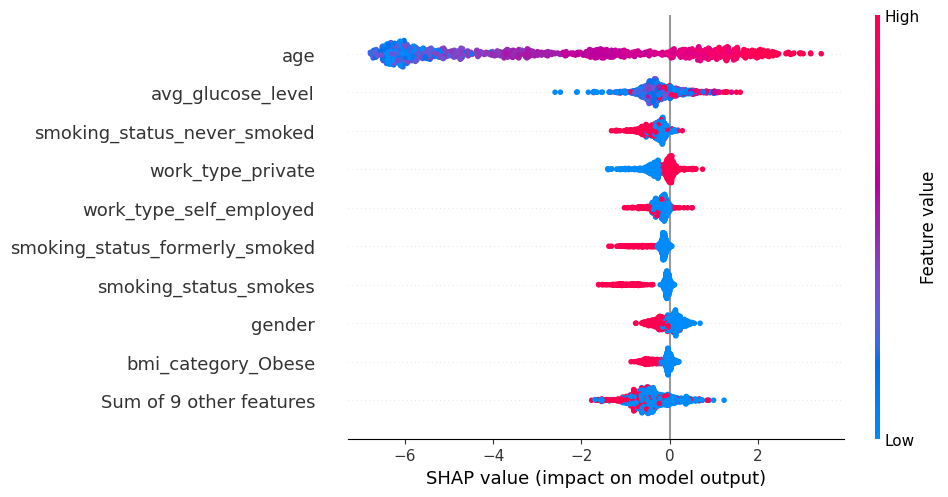

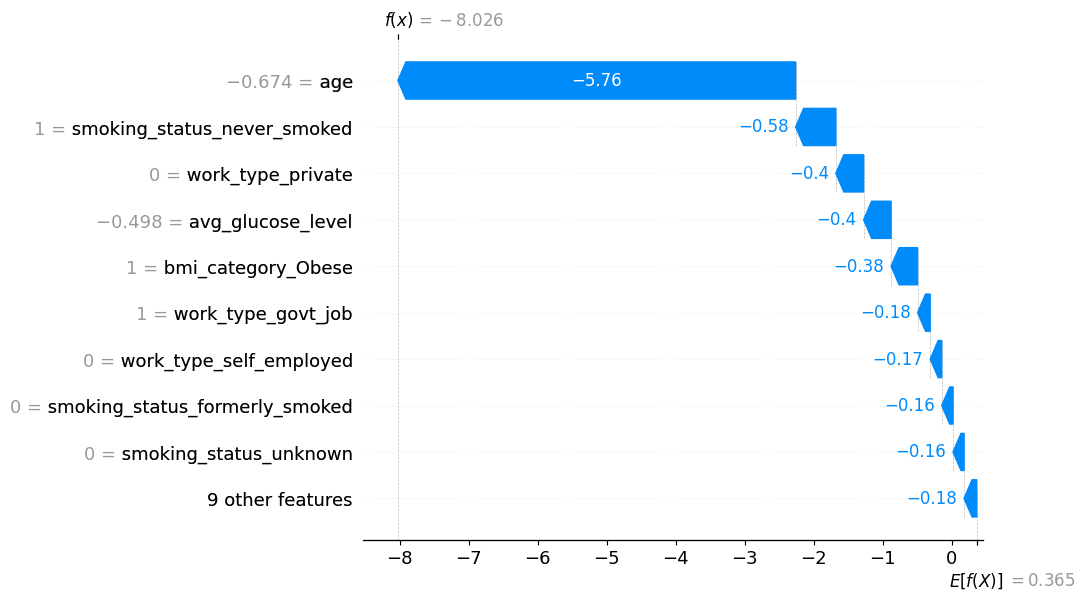

In [4]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in feature_names]

explainer_xgb = shap.Explainer(xgb_model, X_train_balanced, feature_names=clean_feature_names)
explainer_lgbm = shap.Explainer(lgbm_model, X_train_balanced, feature_names=clean_feature_names)

shap_values_xgb = explainer_xgb(X_test_processed)
shap_values_lgbm = explainer_lgbm(X_test_processed)


ensemble_shap_values = shap.Explanation(
    values=(shap_values_xgb.values + shap_values_lgbm.values) / 2,
    base_values=(shap_values_xgb.base_values + shap_values_lgbm.base_values) / 2,
    data=shap_values_xgb.data,
    feature_names=clean_feature_names
)

# Global 
shap.summary_plot(ensemble_shap_values, features=X_test_processed, feature_names=clean_feature_names)
shap.plots.beeswarm(ensemble_shap_values)

# Local
shap.plots.waterfall(ensemble_shap_values[0])